# Baseline model 
The baseline is a Logistic Regression classifier trained on handcrafted ECG features: mean heart rate, variance of R-R intervals, QRS width/amplitude, and T-wave presence. These features are commonly used in clinical ECG analysis and can be easily incorporated into scikit-learn. This provides a benchmark which my deep learning model can be compared to.

In [2]:
%pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from scipy import signal
from scipy.interpolate import interp1d
import torch
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import wfdb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#### Preprocessing Functions

In [3]:
PTB_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
MITDB_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
FEATURE_NAMES = [
    'mean_hr', 'rr_variance', 'mean_rr', 'sdnn', 'rmssd',
    'qrs_width_mean', 'qrs_amplitude_mean', 
    'signal_mean', 'signal_std', 'signal_max'
]

def bandpass_filter(ecg_signal, lowcut=0.5, highcut=40, fs=100, order=4):
    """
    Apply bandpass filter (0.5-40 Hz) to remove baseline drift and noise.
    
    Args:
        ecg_signal: 1D numpy array of ECG signal
        lowcut: Low frequency cutoff (Hz)
        highcut: High frequency cutoff (Hz)
        fs: Sampling frequency (Hz)
        order: Filter order
        
    Returns:
        filtered_signal: Filtered ECG signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, ecg_signal)
    return filtered_signal

def normalize_zscore(ecg_signal):
    """
    Apply Z-score normalization for consistent amplitude scaling.
    
    Args:
        ecg_signal: 1D numpy array
        
    Returns:
        normalized_signal: Z-score normalized signal
    """
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal)
    if std == 0:
        return ecg_signal - mean
    return (ecg_signal - mean) / std

def segment_ecg(ecg_signal, window_size=10, fs=100):
    """
    Split ECG into fixed-length windows.
    
    Args:
        ecg_signal: 1D numpy array
        window_size: Window length in seconds
        fs: Sampling frequency
        
    Returns:
        segments: List of ECG segments
    """
    samples_per_window = window_size * fs
    num_windows = len(ecg_signal) // samples_per_window
    segments = []
    
    for i in range(num_windows):
        start_idx = i * samples_per_window
        end_idx = start_idx + samples_per_window
        segments.append(ecg_signal[start_idx:end_idx])
    
    return segments

def resample_signal(ecg_signal, original_fs=360, target_fs=100):
    """
    Resample signal from original_fs to target_fs.
    
    Args:
        ecg_signal: 1D numpy array
        original_fs: Original sampling frequency
        target_fs: Target sampling frequency
        
    Returns:
        resampled_signal: Resampled ECG signal
    """
    original_time = np.arange(len(ecg_signal)) / original_fs
    target_samples = int(len(ecg_signal) * target_fs / original_fs)
    target_time = np.arange(target_samples) / target_fs
    
    interpolator = interp1d(original_time, ecg_signal, kind='linear', fill_value='extrapolate')
    resampled_signal = interpolator(target_time)
    
    return resampled_signal

def detect_r_peaks(ecg_signal, fs=100):
    """
    Detect R-peaks in ECG signal.
    
    Args:
        ecg_signal: 1D numpy array
        fs: Sampling frequency
        
    Returns:
        peaks: Indices of detected R-peaks
    """
    b, a = signal.butter(2, [5, 15], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, ecg_signal)
    peaks, _ = signal.find_peaks(filtered, distance=fs*0.5, prominence=0.3)
    return peaks

def extract_ecg_features(ecg_signal, fs=100):
    """
    Extract handcrafted ECG features.
    
    Args:
        ecg_signal: ECG signal (can be multi-lead)
        fs: Sampling frequency
        
    Returns:
        features: Dictionary of extracted features
    """
    features = {}
    
    # Use single lead
    signal_lead = ecg_signal[:, 0] if ecg_signal.ndim > 1 else ecg_signal
    
    # Detect R-peaks
    r_peaks = detect_r_peaks(signal_lead, fs)
    
    if len(r_peaks) < 2:
        return {
            'mean_hr': 0, 'rr_variance': 0, 'mean_rr': 0,
            'sdnn': 0, 'rmssd': 0, 
            'qrs_width_mean': 0, 'qrs_amplitude_mean': 0,
            'signal_mean': np.mean(signal_lead),
            'signal_std': np.std(signal_lead),
            'signal_max': np.max(signal_lead)
        }
    
    # R-R intervals
    rr_intervals = np.diff(r_peaks) / fs
    
    # Heart rate features
    features['mean_hr'] = 60 / np.mean(rr_intervals)
    features['rr_variance'] = np.var(rr_intervals)
    features['mean_rr'] = np.mean(rr_intervals)
    features['sdnn'] = np.std(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    
    # QRS features
    qrs_widths = []
    qrs_amplitudes = []
    
    for peak in r_peaks:
        start = max(0, peak - int(0.08 * fs))
        end = min(len(signal_lead), peak + int(0.08 * fs))
        qrs_segment = signal_lead[start:end]
        qrs_widths.append((end - start) / fs)
        qrs_amplitudes.append(np.max(qrs_segment) - np.min(qrs_segment))
    
    features['qrs_width_mean'] = np.mean(qrs_widths)
    features['qrs_amplitude_mean'] = np.mean(qrs_amplitudes)
    
    # Signal statistics
    features['signal_mean'] = np.mean(signal_lead)
    features['signal_std'] = np.std(signal_lead)
    features['signal_max'] = np.max(signal_lead)
    
    return features


#### Data Loading

In [4]:
class ECGFeatureDataset(Dataset):
    """Dataset for ECG features and labels."""
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def aggregate_diagnostic(y_dic, agg_df):
    """
    Map PTB-XL diagnostic codes to our 4 target classes.
    
    Args:
        y_dic: Dictionary of diagnostic codes from PTB-XL
        agg_df: Dataframe with diagnostic mappings
        
    Returns:
        List of target class labels
    """
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            cls = agg_df.loc[key].diagnostic_class
            if cls == 'NORM':
                tmp.append('Normal')
            elif cls == 'MI':
                tmp.append('MI')
            elif 'AFIB' in key or 'AFLT' in key:
                tmp.append('AFib')
            elif cls == 'CD':
                tmp.append('BBB')
    return list(set(tmp))

def map_mitdb_annotation(symbol):
    """
    Map MIT-BIH beat annotations to our 4 target classes.
    
    Args:
        symbol: MIT-BIH annotation symbol
        
    Returns:
        Class label or None
    """
    if symbol in ['N', 'L', 'R', 'e', 'j']:
        return 'Normal'
    elif symbol in ['A', 'a', 'J', 'S']:
        return 'AFib'
    elif symbol in ['V', 'E']:
        return 'MI'
    elif symbol in ['R', 'L']:
        return 'BBB'
    return None
def load_ptbxl_data():
    """
    Load and preprocess PTB-XL dataset sequentially (safe for VS Code / Windows).
    """
    print("\n" + "=" * 80)
    print("LOADING PTB-XL DATASET")
    print("=" * 80)
    

    ptb_data = pd.read_csv(PTB_PATH + 'ptbxl_database.csv', index_col='ecg_id')
    ptb_data.scp_codes = ptb_data.scp_codes.apply(lambda x: eval(x))
    print(f"Loaded {len(ptb_data)} records")
    

    agg_df = pd.read_csv(PTB_PATH + 'scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]
    
    # Map to our 4 classes
    ptb_data['target_class'] = ptb_data.scp_codes.apply(lambda x: aggregate_diagnostic(x, agg_df))
    ptb_filtered = ptb_data[ptb_data.target_class.apply(lambda x: len(x) == 1)]
    ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])
    
    print(f"Filtered to {len(ptb_filtered)} single-label records")
    print("\nClass distribution:")
    print(ptb_filtered['label'].value_counts())
    
    print("\nProcessing signals...")
    features, labels = [], []
    
    for idx, row in ptb_filtered.iterrows():
        try:
            filename = row['filename_lr']
            record = wfdb.rdrecord(PTB_PATH + filename)
            ecg_signal = record.p_signal
            lead_signal = ecg_signal[:, 0]
            
            filtered = bandpass_filter(lead_signal, fs=100)
            normalized = normalize_zscore(filtered)
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                feat = extract_ecg_features(segment, fs=100)
                features.append(list(feat.values()))
                labels.append(row['label'])
            
            if len(features) % 1000 == 0:
                print(f"  Processed {len(features)} segments...")
                
        except Exception as e:
            continue
    
    print(f"✓ PTB-XL complete: {len(features)} segments")
    return features, labels
def load_mitdb_data():
    """
    Load and preprocess MIT-BIH dataset.
    
    Returns:
        features: List of feature vectors
        labels: List of labels
    """
    print("\n" + "=" * 80)
    print("LOADING MIT-BIH DATASET")
    print("=" * 80)
    
    mitdb_records = [
        '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
        '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
        '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
        '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
        '222', '223', '228', '230', '231', '232', '233', '234'
    ]
    
    print("Processing signals...")
    features = []
    labels = []
    
    for record_name in mitdb_records:
        try:
            record = wfdb.rdrecord(MITDB_PATH + record_name)
            annotation = wfdb.rdann(MITDB_PATH + record_name, 'atr')
            
            ecg_signal = record.p_signal[:, 0]
            resampled = resample_signal(ecg_signal, original_fs=360, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            r_peaks = detect_r_peaks(normalized, fs=100)
            
            window_samples = 10 * 100
            
            for peak in r_peaks[::5]:
                start = max(0, peak - window_samples // 2)
                end = min(len(normalized), peak + window_samples // 2)
                
                if end - start == window_samples:
                    segment = normalized[start:end]
                    segment_annotations = annotation.symbol[
                        (annotation.sample >= start * 360/100) & 
                        (annotation.sample < end * 360/100)
                    ]
                    
                    if len(segment_annotations) > 0:
                        unique, counts = np.unique(segment_annotations, return_counts=True)
                        dominant_annotation = unique[np.argmax(counts)]
                        label = map_mitdb_annotation(dominant_annotation)
                        
                        if label:
                            feat = extract_ecg_features(segment, fs=100)
                            features.append(list(feat.values()))
                            labels.append(label)
            
            if len(features) % 500 == 0:
                print(f"  Processed {len(features)} segments...")
                
        except Exception as e:
            continue
    
    print(f"✓ MIT-BIH complete: {len(features)} segments")
    return features, labels
    

In [ ]:
def get_data_loaders(features, labels, batch_size=64):
    """
    Create train/val/test data loaders with random sampling.
    
    Args:
        features: numpy array of features
        labels: numpy array of labels
        batch_size: batch size for data loaders
        
    Returns:
        train_loader: training data loader
        val_loader: validation data loader
        test_loader: test data loader
        classes: list of class names
    """
   
    dataset = ECGFeatureDataset(features, labels)
    
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
    
    train_split = int(0.7 * dataset_size)
    val_split = int(0.85 * dataset_size)
    
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
   
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
   
    classes = list(set(labels))
    
    print(f"\nDataset split:")
    print(f"  Training: {len(train_indices)} samples ({len(train_indices)/dataset_size*100:.1f}%)")
    print(f"  Validation: {len(val_indices)} samples ({len(val_indices)/dataset_size*100:.1f}%)")
    print(f"  Test: {len(test_indices)} samples ({len(test_indices)/dataset_size*100:.1f}%)")
    
    return train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices


In [6]:
ptb_features, ptb_labels = load_ptbxl_data()
mitdb_features, mitdb_labels = load_mitdb_data()

X_all = np.array(ptb_features + mitdb_features)
y_all = np.array(ptb_labels + mitdb_labels)

print(f"Total samples: {len(X_all)}")
print(f"  PTB-XL: {len(ptb_features)}")
print(f"  MIT-BIH: {len(mitdb_features)}")
print(f"\nClass distribution:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_all)*100:.1f}%)")

train_loader, val_loader, test_loader, classes, train_idx, val_idx, test_idx = get_data_loaders(
    X_all, y_all, batch_size=64
)

X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_val = X_all[val_idx]
y_val = y_all[val_idx]
X_test = X_all[test_idx]
y_test = y_all[test_idx]


LOADING PTB-XL DATASET
Loaded 21837 records


C:\Users\sharm\AppData\Local\Temp\ipykernel_2836\1656333638.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])


Filtered to 15490 single-label records

Class distribution:
label
Normal    9113
MI        3685
BBB       2692
Name: count, dtype: int64

Processing signals...
  Processed 1000 segments...
  Processed 2000 segments...
  Processed 3000 segments...
  Processed 4000 segments...
  Processed 5000 segments...
  Processed 6000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 9000 segments...
  Processed 10000 segments...
  Processed 11000 segments...
  Processed 12000 segments...
  Processed 13000 segments...
  Processed 14000 segments...
  Processed 15000 segments...
✓ PTB-XL complete: 15490 segments

LOADING MIT-BIH DATASET
Processing signals...
✓ MIT-BIH complete: 0 segments
Total samples: 15490
  PTB-XL: 15490
  MIT-BIH: 0

Class distribution:
  BBB: 2692 (17.4%)
  MI: 3685 (23.8%)
  Normal: 9113 (58.8%)

Dataset split:
  Training: 10843 samples (70.0%)
  Validation: 2323 samples (15.0%)
  Test: 2324 samples (15.0%)


#### Training the baseline

In [ ]:
print("\n" + "=" * 80)
print("TRAINING BASELINE MODEL")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, 
                          multi_class='multinomial', solver='lbfgs')

print("Training Logistic Regression...")
start_time = time.time()
model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"✓ Training complete ({train_time:.2f}s)")


y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nResults:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Train F1: {train_f1:.4f}")
print(f"  Test F1: {test_f1:.4f}")

print("\n" + classification_report(y_test, y_pred_test))


TRAINING BASELINE MODEL
Training Logistic Regression...
✓ Training complete (0.05s)

Results:
  Train Accuracy: 0.6113
  Test Accuracy: 0.6119
  Train F1: 0.5251
  Test F1: 0.5307

              precision    recall  f1-score   support

         BBB       0.69      0.24      0.35       421
          MI       0.39      0.08      0.13       550
      Normal       0.62      0.94      0.75      1353

    accuracy                           0.61      2324
   macro avg       0.57      0.42      0.41      2324
weighted avg       0.58      0.61      0.53      2324



c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# Actual Model: 

In [13]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


#### Supporting Functions

In [ ]:
print("\n" + "=" * 80)
print("BUILDING CNN-TRANSFORMER MODEL")
print("=" * 80)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

def load_ptbxl_signals():
    """Load PTB-XL raw signals for CNN-Transformer."""
    print("\n" + "=" * 80)
    print("LOADING PTB-XL RAW SIGNALS")
    print("=" * 80)
    
    ptb_data = pd.read_csv(PTB_PATH + 'ptbxl_database.csv', index_col='ecg_id')
    ptb_data.scp_codes = ptb_data.scp_codes.apply(lambda x: eval(x))
    
    agg_df = pd.read_csv(PTB_PATH + 'scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]
    
    ptb_data['target_class'] = ptb_data.scp_codes.apply(lambda x: aggregate_diagnostic(x, agg_df))
    ptb_filtered = ptb_data[ptb_data.target_class.apply(lambda x: len(x) == 1)]
    ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])
    
    print(f"Processing {len(ptb_filtered)} records...")
    signals, labels = [], []
    
    for idx, row in ptb_filtered.iterrows():
        try:
            filename = row['filename_lr']
            record = wfdb.rdrecord(PTB_PATH + filename)
            ecg_signal = record.p_signal
            lead_signal = ecg_signal[:, 0]
            
            filtered = bandpass_filter(lead_signal, fs=100)
            normalized = normalize_zscore(filtered)
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                signals.append(segment)
                labels.append(row['label'])
            
            if len(signals) % 1000 == 0:
                print(f"  Processed {len(signals)} segments...")
                
        except Exception as e:
            print(f"ERROR on PTB-XL record {idx}: {e}")
            continue
    
    print(f"✓ PTB-XL complete: {len(signals)} segments")
    return signals, labels

def load_mitdb_signals():
    """Load MIT-BIH raw signals for CNN-Transformer."""
    print("\n" + "=" * 80)
    print("LOADING MIT-BIH RAW SIGNALS")
    print("=" * 80)
    
    mitdb_records = [
        '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
        '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
        '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
        '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
        '222', '223', '228', '230', '231', '232', '233', '234'
    ]
    
    print("Processing signals...")
    signals, labels = [], []
    
    for record_name in mitdb_records:
        try:
            record = wfdb.rdrecord(MITDB_PATH + record_name)
            annotation = wfdb.rdann(MITDB_PATH + record_name, 'atr')
            
            ecg_signal = record.p_signal[:, 0]
            resampled = resample_signal(ecg_signal, original_fs=360, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            r_peaks = detect_r_peaks(normalized, fs=100)
            
            window_samples = 10 * 100
            
            for peak in r_peaks[::5]:
                start = max(0, peak - window_samples // 2)
                end = min(len(normalized), peak + window_samples // 2)
                
                if end - start == window_samples:
                    segment = normalized[start:end]
                    segment_annotations = annotation.symbol[
                        (annotation.sample >= start * 360/100) & 
                        (annotation.sample < end * 360/100)
                    ]
                    
                    if len(segment_annotations) > 0:
                        unique, counts = np.unique(segment_annotations, return_counts=True)
                        dominant_annotation = unique[np.argmax(counts)]
                        label = map_mitdb_annotation(dominant_annotation)
                        
                        if label:
                            signals.append(segment)
                            labels.append(label)
            
            if len(signals) % 500 == 0:
                print(f"  Processed {len(signals)} segments...")
                
        except Exception as e:
            print(f"ERROR on MIT-BIH record {record_name}: {e}")  # ← NOW PRINTS ERRORS!
            continue
    
    print(f"✓ MIT-BIH complete: {len(signals)} segments")
    return signals, labels

class ECGSignalDataset(Dataset):
    """Dataset for raw ECG signals with data augmentation."""
    
    def __init__(self, signals, labels, label_encoder, augment=False):
        self.signals = torch.FloatTensor(signals).unsqueeze(1)
        self.labels = torch.LongTensor(label_encoder.transform(labels))
        self.augment = augment
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx]
        
        if self.augment:
            noise = torch.randn_like(signal) * 0.05
            signal = signal + noise
            
            scale = torch.FloatTensor(1).uniform_(0.9, 1.1)
            signal = signal * scale
        
        return signal, self.labels[idx]

class CNNTransformerECG(nn.Module):
    """CNN-Transformer for ECG classification."""
    
    def __init__(self, num_classes=4):
        super(CNNTransformerECG, self).__init__()
    
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        
        self.sequence_length = 125
        self.d_model = 256

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=8,
            dim_feedforward=512,
            dropout=0.2,  
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc1 = nn.Linear(self.d_model * self.sequence_length, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = x.permute(0, 2, 1)
        x = self.transformer(x)
       
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

def get_model_name(name, batch_size, learning_rate, epoch):
    """Generate model name."""
    return f"model_{name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"

def train(model, train_loader, val_loader, num_epochs=20, learning_rate=0.0001, batch_size=32, name="cnn_transformer"):
    """Train CNN-Transformer model."""
    torch.manual_seed(RANDOM_SEED)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")
    
    print("Training Started...")
    
    for epoch in range(num_epochs):
       
        model.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train_err += (preds != labels).sum().item()
            total_samples += labels.size(0)
        
        train_loss[epoch] = total_train_loss / len(train_loader)
        train_err[epoch] = total_train_err / total_samples
       
        model.eval()
        val_total_loss = 0.0
        val_total_err = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_total_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total_err += (preds != labels).sum().item()
                val_samples += labels.size(0)
        
        val_loss[epoch] = val_total_loss / len(val_loader)
        val_err[epoch] = val_total_err / val_samples
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss[epoch]:.4f} | "
              f"Val Loss: {val_loss[epoch]:.4f} | "
              f"Train Err: {train_err[epoch]*100:.2f}% | "
              f"Val Err: {val_err[epoch]*100:.2f}%")
        
        model_path = get_model_name(name, batch_size, learning_rate, epoch+1)
        torch.save(model.state_dict(), model_path + ".pth")
    
    model_path = get_model_name(name, batch_size, learning_rate, num_epochs)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)
    
    return train_err, val_err, train_loss, val_loss

def plot_training_curve(path):
    """Plot training curves."""
    train_err = np.loadtxt(f"{path}_train_err.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")
    
    n = len(train_err)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n+1), train_err, label='Train Error')
    plt.plot(range(1, n+1), val_err, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Train vs Validation Error')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n+1), train_loss, label='Train Loss')
    plt.plot(range(1, n+1), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def get_dl_data_loaders(signals, labels, batch_size=32):
    """Create data loaders with augmentation for training."""
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    
    dataset_size = len(signals)
    indices = list(range(dataset_size))
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
    
    train_split = int(0.7 * dataset_size)
    val_split = int(0.85 * dataset_size)
    
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    
    train_signals = [signals[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    train_dataset = ECGSignalDataset(train_signals, train_labels, label_encoder, augment=True)
    
    val_signals = [signals[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    val_dataset = ECGSignalDataset(val_signals, val_labels, label_encoder, augment=False)
    
    test_signals = [signals[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]
    test_dataset = ECGSignalDataset(test_signals, test_labels, label_encoder, augment=False)
 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Dataset split: {len(train_indices)}/{len(val_indices)}/{len(test_indices)}")
    return train_loader, val_loader, test_loader, label_encoder


#### Training the model


BUILDING CNN-TRANSFORMER MODEL

LOADING PTB-XL RAW SIGNALS


C:\Users\sharm\AppData\Local\Temp\ipykernel_2836\3408819836.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])


Processing 15490 records...
  Processed 1000 segments...
  Processed 2000 segments...
  Processed 3000 segments...
  Processed 4000 segments...
  Processed 5000 segments...
  Processed 6000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 9000 segments...
  Processed 10000 segments...
  Processed 11000 segments...
  Processed 12000 segments...
  Processed 13000 segments...
  Processed 14000 segments...
  Processed 15000 segments...
✓ PTB-XL complete: 15490 segments

LOADING MIT-BIH RAW SIGNALS
Processing signals...
ERROR on MIT-BIH record 100: only integer scalar arrays can be converted to a scalar index
ERROR on MIT-BIH record 101: only integer scalar arrays can be converted to a scalar index
ERROR on MIT-BIH record 102: only integer scalar arrays can be converted to a scalar index
ERROR on MIT-BIH record 103: only integer scalar arrays can be converted to a scalar index
ERROR on MIT-BIH record 104: only integer scalar arrays can be converted to a scal

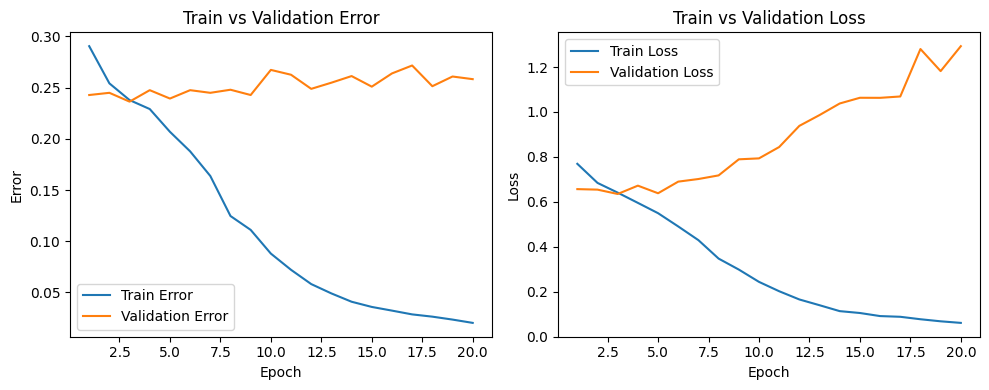

✓ Training complete!


In [ ]:

ptb_signals, ptb_labels_dl = load_ptbxl_signals()
mitdb_signals, mitdb_labels_dl = load_mitdb_signals()

all_signals = ptb_signals + mitdb_signals
all_labels_dl = ptb_labels_dl + mitdb_labels_dl

print(f"\nTotal: {len(all_signals)} signals")

BATCH_SIZE = 32
LEARNING_RATE = 0.0001 
NUM_EPOCHS = 20

dl_train_loader, dl_val_loader, dl_test_loader, label_encoder = get_dl_data_loaders(
    all_signals, all_labels_dl, batch_size=BATCH_SIZE
)

model = CNNTransformerECG(num_classes=4)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

train_err, val_err, train_loss, val_loss = train(
    model, dl_train_loader, dl_val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    name="ecg_cnn_transformer"
)

model_path = get_model_name("ecg_cnn_transformer", BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS)
plot_training_curve(model_path)

print("✓ Training complete!")



# Checking Test data accuracy

In [20]:
def get_accuracy(model, data_loader):
    """Calculate accuracy on a dataset."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for signals, labels in data_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate test accuracy
test_acc = get_accuracy(model, dl_test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 74.01%
